In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

In [126]:
df = pd.read_csv('./data_ari.csv', index_col=0)

In [127]:
BEGINING = '2017-12-31'


class Maintenance:
    def __init__(self, df: pd.core.frame.DataFrame):
        self.df = df

    def fill_na(self):
        '''fill the missing values for the review'''
        value = self.df.mean_review_score.mean()
        self.df.mean_review_score.fillna(value=value, inplace=True)

    def date_convertor(self,
                       serie: pd.core.series.Series) -> pd.core.series.Series:
        '''take a pandas serie and return it in format datetime'''
        return pd.to_datetime(serie, format="%Y-%m-%d %H:%M:%S", )

    def normalisation(self, features_to_normalized, default=False):
        '''if set to true, normalised data'''
        if default:
            for feature in features_to_normalized:
                scaler = StandardScaler()
                self.df[feature] = scaler.fit_transform(self.df[[feature]])
        return self.df

    def clean_data(self,
                   data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        '''take data with potencialy multiple orders for a customer and return
        data with only '''
        data = data[['customer_unique_id',
                     'recently_order',
                     'mean_order_price',
                     'cum_sum_order',
                     'number_of_orders',
                     'mean_review_score']].drop_duplicates()
        return data

    def creating_ari_data(self) -> dict:
        '''create a dictionary key=timedelta and value=dataframe'''
        self.df.order_delivered_customer_date = self.date_convertor(
            self.df.order_delivered_customer_date)
        MAX_DATE = max(self.df.order_delivered_customer_date)
        data_to_ari = {}
        for i in range(0, 1500, 15):
            date = pd.to_datetime(BEGINING)+pd.Timedelta(days=i)
            if date < MAX_DATE:
                data_ari = self.df[
                    self.df.order_delivered_customer_date < date]
                data_ari = self.clean_data(data_ari)
                data_to_ari[i] = data_ari
        return data_to_ari


In [128]:
N_CLUSTERS = 5


class AriCalculation:
    def __init__(self, data: dict):
        self.data = data

    def features_maker(self, timedelta: int) -> pd.core.frame.DataFrame:
        '''remove the customer_unique_id column'''
        X = self.data[timedelta].drop(columns=['customer_unique_id'])
        return X

    def model_training(self, timedelta: int) -> KMeans:
        '''return a fitted model'''
        model = KMeans(n_clusters=N_CLUSTERS)
        model.fit(self.features_maker(timedelta))
        return model

    def ari_calculation(self) -> dict:
        '''create a dictionary
        keys: timedelta
        values: ari beetween model t0 and t0+1, ect'''
        ari_results = {}
        for timedelta in self.data.keys():
            if timedelta == 0:
                self.base_model = self.model_training(timedelta)
            else:
                model_timedelta = self.model_training(timedelta)
                X = self.features_maker(timedelta)
                prediction = self.base_model.predict(X)
                truth = model_timedelta.predict(X)
                ari = adjusted_rand_score(truth, prediction)
                ari_results[timedelta] = ari
        return ari_results

    def simulation(self, days: int) -> dict:
        '''calculates ari with a different t0
        plot the graph'''
        ari_results = {}
        for timedelta in self.data.keys():
            if timedelta < days:
                pass
            elif timedelta == days:
                self.base_model = self.model_training(timedelta)
            else:
                model_timedelta = self.model_training(timedelta)
                X = self.features_maker(timedelta)
                prediction = self.base_model.predict(X)
                truth = model_timedelta.predict(X)
                ari = adjusted_rand_score(truth, prediction)
                ari_results[timedelta] = ari
        return ari_results

    def ploting_ari(self, days, calculation=True) -> dict:
        '''plot lineplot dictionary
        keys: timedelta,
        values: ari beetween model t0 and t0+1, ect
        return this dictionary '''
        if calculation:
            ari_results = self.ari_calculation()
        else:
            ari_results = self.simulation(days)
        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(20, 10))
        sns.lineplot(ari_results.keys(), ari_results.values(),
                     markers=True, legend='full', )
        sns.lineplot(ari_results.keys(),
                     0.8,
                     linestyle='--',
                     legend='full')
        plt.xticks(list(ari_results.keys()))
        plt.show()
        return ari_results


In [129]:
data = Maintenance(df)
data.fill_na()
data.normalisation(['recently_order',
                    'mean_order_price',
                    'cum_sum_order',
                    'number_of_orders',
                    'mean_review_score'], True)
data_ari = data.creating_ari_data()

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


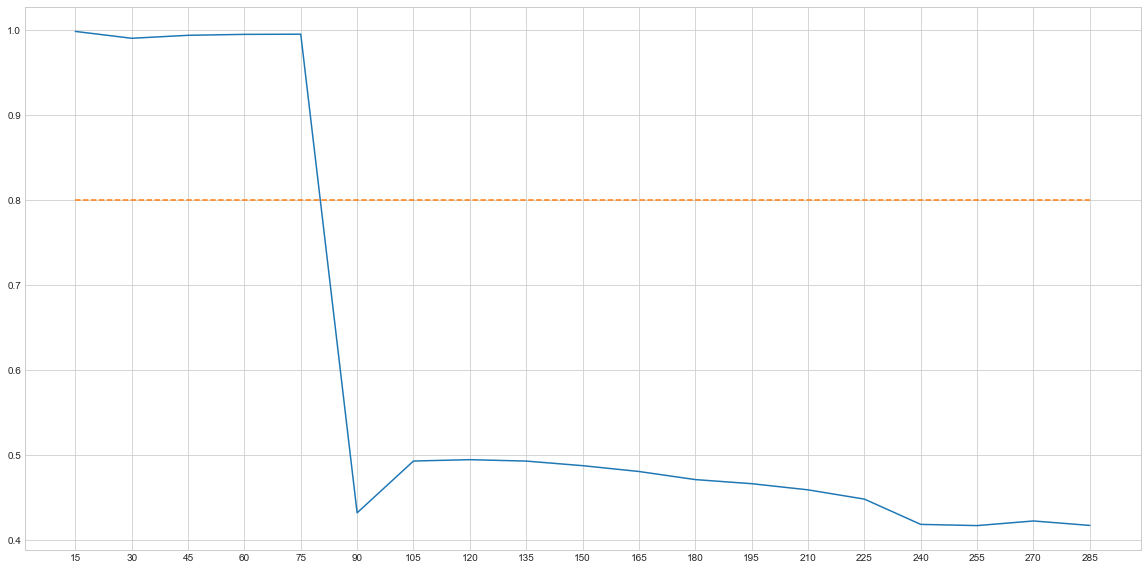

In [130]:
ari_results = AriCalculation(data_ari).ploting_ari(0)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


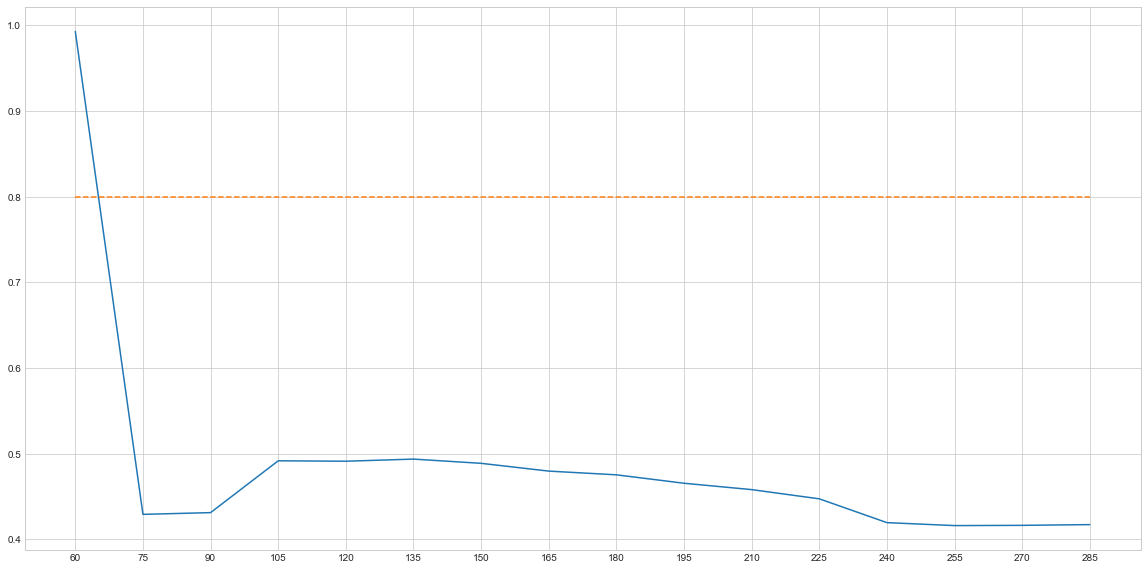

In [131]:
ari_results = AriCalculation(data_ari).ploting_ari(45, False)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


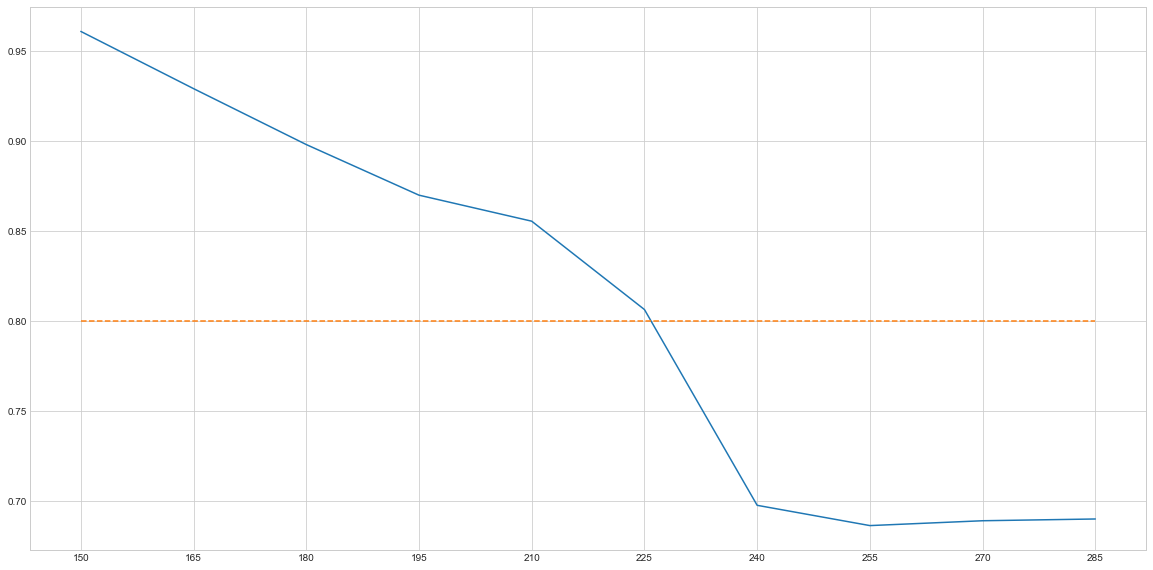

In [159]:
ari_results = AriCalculation(data_ari).ploting_ari(135, False)

In [29]:
ari_results

{165: 0.9557136544397445,
 180: 0.9328327421597634,
 195: 0.901299426660814,
 210: 0.8836143091571479,
 225: 0.8424813121354491,
 240: 0.7186506480558463,
 255: 0.7108373205522767,
 270: 0.7098662877990077,
 285: 0.7075022198345046}

In [157]:
# date = pd.to_datetime(BEGINING)+pd.Timedelta(days=60)